In [154]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
from scipy.linalg import eigh


#tqdm=aux

In [ ]:
%history

In [146]:
class Log:
    def __init__(self):
        self.log={'grad': [],'x':[],'f':[]}
    def __getitem__(self,k):
        return np.asarray(self.log[k])
    def to_numpy(self):
        a=np.stack(np.asarray(v) for v in self.log.values())
        return a,self.log.keys()
    def __call__(self,f,x): 
        
        self.log['grad'].append(np.linalg.norm(f.grad(x))**2)
        self.log['x'].append(np.linalg.norm(x)**2)
        self.log['f'].append(np.linalg.norm(f(x)**2))
class RandomQuadratic:
    def __init__(self,r=1,sigma=1,n=500):
        m=int(n*r)
        X=np.random.normal(size=(m,n),scale=sigma)
        self.A=1/n*(X@X.T)
        self.x0=np.random.normal(size=(m,1))
        self.L=eigh(self.A,eigvals_only=True,subset_by_index=[m-1,m-1])
        
        
    def plot(self):
        ev,_=np.linalg.eigh(self.A)
        plt.hist(ev[ev<100],bins=30)
        plt.show()
    
    def __call__(self,x):
        return 1/2* x.T@self.A@x
    
    def grad(self,x):
        return self.A@x
    
    
class FeaturesQuadratic(Quadratic):
    def __init__(self,X,y,torch=False):
        self.X=X/np.sqrt(X.shape[0])
        self.A=self.X.T@self.X
        if torch:
            self.x0=torch.randn((self.X.shape[1],1),device='cuda')
        else:
            self.x0=np.random.normal(size=(self.X.shape[1],1))
        self.y=y[:,None]
        m=len(self.A)
        self.L=eigh(self.A,eigvals_only=True,subset_by_index=[m-1,m-1])
        
    def plot(self):
        ev,_=np.linalg.eigh(self.A)
        plt.hist(ev[ev<100],bins=30)
        plt.show()
    
    def __call__(self,x):
        return 1/2*np.linalg.norm(self.X@x-self.y)**2
    
    def grad(self,x):
        return self.X.T@(self.X@x-self.y)
    
def nesterov(f,niter=200,L=4):
    x=0
    y=f.x0
    alpha=1/L
    log=Log()
    for k in tqdm(range(1,niter+1)):
        beta=k/(k+3)
        x1=y-alpha*f.grad(y)
        y=x1+beta*(x1-x)
        x=x1
        #x=x-alpha*f.grad(x)
        ##log
        log(f,x)
        
    return log,x

def gd(f,niter=200,L=4):
    x=f.x0
    alpha=1/L
    log=Log()
    for k in tqdm(range(1,niter+1)):
        x=x-alpha*f.grad(x)
        log(f,x)
        
    return log,x

def cg(f,niter=200):
    ## as in https://www.cs.cmu.edu/~quake-papers/painless-conjugate-gradient.pdf p.32
    x=f.x0
    d=r=-f.grad(x)
    A=f.A
    log=Log()
    for i in range(1,niter+1):
        alpha=r.T@r/(d.T@A@d)
        x=x+alpha*d
        
        r1=-f.grad(x)
        beta=r1.T@r1/(r.T@r)
        r=r1
        
        d=r+beta*d
        
        log(f,x)
    
    return log,x
def mp_momentum(f,niter=200,sigma=1,r=1):
    x1=x=f.x0
    delta=0
    rho=(1+r)/np.sqrt(r)
    log=Log()
    
    for t in range(1,niter+1):
        delta=-1/(rho+delta)
        
        aux=x
        x=x+(1+rho*delta)*(x1-x)+delta/(np.sqrt(r)*sigma**2)*f.grad(x)
        x1=aux
        
        log(f,x)        
    return log,x


def jacobi_momentum(f,niter=200,b=2,L=4):
    x1=x=f.x0
    delta=0
    log=Log()
    for t in tqdm(range(1,niter+1)):
        t2=t**2
        alpha=-(b+2*t)*(2*b**2+4*b*t+b+4*t2-1)
        alpha/=2*t*(b+t+1)*(b+2*t-1)
        
        beta=(b+2*t)*(b+2*t+1)/(L*t*(b+t+1))
        
        gamma=-(t-1/2)*(b+t-1/2)*(b+2*t+1)
        gamma/=t*(b+t+1)*(b+2*t-1)
        
        delta=1/(alpha+gamma*delta)
        
        a,bt=delta*alpha,delta*beta
        
        aux=x
        x=x+(1-a)*(x1-x)+bt*f.grad(x)
        x1=aux
        
        log(f,x)        
    return log,x



In [147]:
for _ in range(10):
    f=RandomQuadratic()
    print(f.L)

[3.86648687]
[3.92152317]
[4.03236811]
[3.9472663]
[3.91388577]
[3.96523446]
[3.98248143]
[3.91193053]
[3.84839272]
[3.8573666]


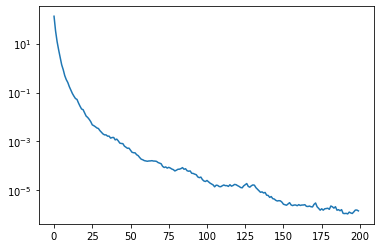

In [136]:
f=RandomQuadratic()


log,_=cg(f)
plt.semilogy(log['grad'])
        

## MP distribution

100%|██████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 7427.03it/s]
C:\Users\leona\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3418: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
100%|██████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 8355.19it/s]


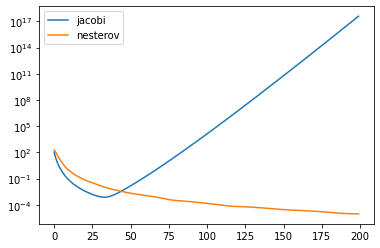

In [163]:
methods,tags=[jacobi_momentum,nesterov],['jacobi','nesterov']
logs=[[] for _ in range(len(methods))]
for _ in range(3):
    for m,l in zip(methods,logs):
        f= RandomQuadratic(r=1)
        l.append(m(f)[0].to_numpy()[0])

logs=[np.stack(l) for l in logs]
for a, tag in zip(logs,tags):
    #a=np.log10(a)
    m,std=a.mean(0),a.std(0)
    #plt.fill_between(np.arange(len(m[1])),m[1]-std[0],m[0]+std[0])
    plt.plot(m[0],label=tag)
plt.yscale('log')
plt.legend()

In [158]:
logs[0].shape

(5, 3, 200)

## Inception Features

In [5]:
import torch
train_y=torch.load('data/labels_cifar_train')
train_data=torch.load('data/cifar_train')

In [58]:
train_y

array([6., 9., 9., ..., 9., 1., 1.])

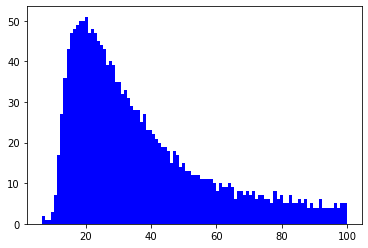

In [137]:
import numpy as np
N=8000
perm=np.random.permutation(np.arange(len(train_data)))
sample=train_data[perm[:N]]
sample=(sample-sample.mean(0))/sample.std(0)
_,evs,_=np.linalg.svd(sample)
plt.hist(evs[evs<100],bins=100,color='b')
nsample=(sample-sample.mean(0))/sample.std()

#_,evs,_=np.linalg.svd(sample)
#plt.hist(evs[evs<100],bins=100,color='r')

(array([167., 465., 354., 241., 159., 108.,  81.,  64.,  54.,  43.,  41.,
         33.,  29.,  24.,  21.,  18.,  16.,  16.,  11.,  11.,  11.,   8.,
          7.,   6.,   4.,   7.,   5.,   4.,   2.,   3.,   4.,   1.,   3.,
          1.,   2.,   2.,   1.,   1.,   1.,   2.,   2.,   0.,   1.,   0.,
          1.,   1.,   1.,   1.,   0.,   1.,   1.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([  6.66231062,  15.63314628,  24.60398195,  33.57481761,
         42.54565328,  51.51648895,  60.48732461,  69.45816028,
         78.42899595,  87.39983161,  96.37066728, 105.34150294,
        114.31233861, 123.28317428, 132.25400994, 141.22484561,
        150.19568127, 159.16651694, 168.13735261, 177.10818827

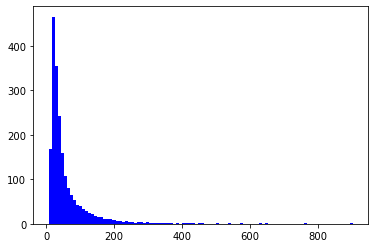

In [138]:
plt.hist(evs,bins=100,color='b')


In [ ]:
t=np.linspace(0.1,100,1000)
egvs=evs[evs<100]
mp=np.sqrt((100-t)/t)
plt.hist(egvs,bins=100)
plt.plot(t,mp)

In [119]:
N=8000
perm=np.random.permutation(np.arange(len(train_data)))
sample_x=train_data[perm[:N]]
sample_y=train_y[perm[:N]]
f=FeaturesQuadratic(sample_x,sample_y)
#f.plot()

In [116]:
evs

array([17.06179184,  3.77166368,  2.89447399,  2.56368501,  2.43707314,
        2.12601258,  2.08103682,  1.98463694,  1.76684252,  1.71113241,
        1.63026029,  1.6164343 ,  1.5493469 ,  1.50744668,  1.49459119,
        1.44793887,  1.40813196,  1.40447398,  1.31879862,  1.3111373 ,
        1.30583274,  1.24961971,  1.24510014,  1.23409002,  1.18977614,
        1.1779173 ,  1.16794107,  1.13556404,  1.12775482,  1.09680336,
        1.08417203,  1.07245297,  1.04838947,  1.03992362,  1.02859104,
        1.00731895,  0.99679464,  0.99436983,  0.98140284,  0.97548197,
        0.9631026 ,  0.9516755 ,  0.94598225,  0.93867832,  0.92680299,
        0.92239862,  0.90973419,  0.90297373,  0.89930026,  0.89127418,
        0.87328922,  0.87178929,  0.85826243,  0.85373019,  0.846113  ,
        0.84062659,  0.83708945,  0.82943015,  0.82656857,  0.81962767,
        0.80656204,  0.80305889,  0.7985843 ,  0.78965294,  0.78035434,
        0.77616935,  0.76739964,  0.76548208,  0.75512564,  0.75

(array([2.039e+03, 7.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([ 0.03573997,  1.73900561,  3.44227125,  5.14553689,  6.84880253,
         8.55206816, 10.2553338 , 11.95859944, 13.66186508, 15.36513072,
        17.06839635]),
 <BarContainer object of 10 artists>)

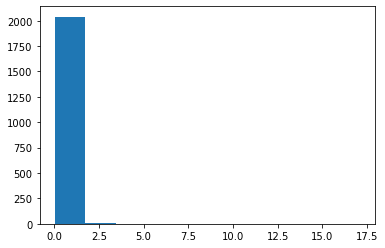

In [122]:
_,evs,_=np.linalg.svd(f.X)
plt.hist(evs)

In [104]:
f.grad(f.x0)

array([[-18.65899467],
       [-41.1547183 ],
       [-41.43940803],
       ...,
       [-72.10967333],
       [-59.49561786],
       [-82.49779108]])

<ipython-input-120-a715a5709cf5>:13: RuntimeWarning: overflow encountered in double_scalars
  self.log['f'].append(np.linalg.norm(f(x)**2))
<ipython-input-97-4a8747d584ed>:51: RuntimeWarning: overflow encountered in matmul
  return self.X.T@(self.X@x-self.y)
<ipython-input-38-ec1cb2c84776>:37: RuntimeWarning: overflow encountered in multiply
  x=x+(1-a)*(x1-x)+bt*f.grad(x)
<ipython-input-97-4a8747d584ed>:51: RuntimeWarning: invalid value encountered in matmul
  return self.X.T@(self.X@x-self.y)
<ipython-input-38-ec1cb2c84776>:37: RuntimeWarning: overflow encountered in add
  x=x+(1-a)*(x1-x)+bt*f.grad(x)
<ipython-input-38-ec1cb2c84776>:37: RuntimeWarning: invalid value encountered in add
  x=x+(1-a)*(x1-x)+bt*f.grad(x)
 68%|██████████████████████████████████████████████████████                          | 135/200 [00:05<00:02, 23.96it/s]<ipython-input-97-4a8747d584ed>:48: RuntimeWarning: invalid value encountered in matmul
  return 1/2*np.linalg.norm(self.X@x-self.y)**2
100%|███████████

C:\Users\leona\anaconda3\lib\site-packages\numpy\ma\core.py:6849: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


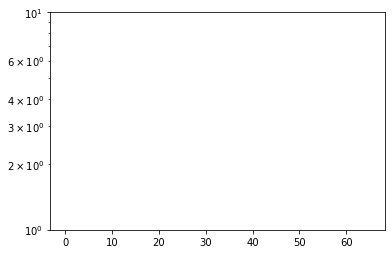

In [123]:
L=3
log1,x1=jacobi_momentum(f,L=L)
log2,x2=nesterov(f,L=L)
plt.semilogy(log1['grad'],c='b')

plt.semilogy(log2['grad'],c='r')

In [96]:
train_y

array([6., 9., 9., ..., 9., 1., 1.])

In [112]:
_,evs

(1000, 2048)

In [108]:
x0=f.x0
print(f(x0)-f(x0-0.001*f.grad(x0)))

4850.974831567333
